In [1]:
import heeps
from heeps.wavefront.get_array import show_wf, get_wf
from heeps.util.img_processing import resize_img
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

### high res ESO pupil: new spider shadow (5x31cm + 1x54cm) added on Nov 2024

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
filename_segpattern = 'eso/SegmentationPattern.fits'
mask_segpattern = fits.getdata(filename_segpattern)

filename_M1 = 'eso/mask_fullM1.fits'
mask_M1 = fits.getdata(filename_M1)

In [ ]:
# save 'mask_spi' to very high res
ngrid = 2**14#2**11
npupil = 10526#1385
conf = dict(
    ngrid = ngrid,
    npupil = npupil,
    pupil_img_size = 39.9988,
    diam_ext = 80,
    diam_int = 0,
    norm_I = False,
    f_pupil = '',
    spi_angles = [60,120,180,240,300],#[0,60,120,180,240,300],
    spi_width = 0.31,#0.54,
    AP_angles = [0],#[],
    AP_width = 0.54,
    add_seg = False,
)
conf = heeps.config.read_config(**conf)

filename_spi = 'eso/SpiderShadow_nov2024.fits'
try:
    mask_spi = fits.getdata(filename_spi)
except FileNotFoundError:
    wf = heeps.pupil.pupil(**conf)
    mask_spi = get_wf(wf, 'amp', npupil=conf['npupil']).astype('uint8')
    fits.writeto(filename_spi, mask_spi)

filename_elt = 'eso/ELT_binary_pupil_10k_nov2024.fits'
try:
    mask_elt = fits.getdata(filename_elt)
except FileNotFoundError:
    mask_elt = mask_segpattern * mask_spi
    fits.writeto(filename_elt, mask_elt)

## 1. No segments, smaller resolution = 1385

In [4]:
# from here, save ELT pupils to a smaller resolution
ngrid = 2**11
npupil = 1385
conf.update(
    ngrid = ngrid,
    npupil = npupil,   
)

In [5]:
# ELT pupil without segments
filename_noseg = 'ELT_fullM1_nov2024_noseg.fits'
try:
    mask_noseg = fits.getdata(filename_noseg)
except FileNotFoundError:
    mask_noseg = resize_img(mask_M1 * mask_spi, npupil)
    fits.writeto(filename_noseg, mask_noseg)

# 2. Add segments

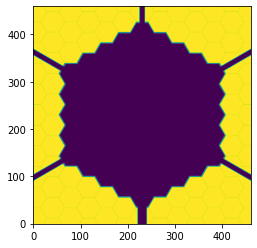

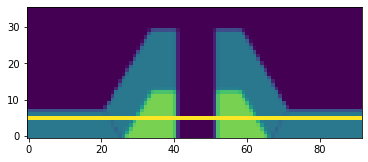

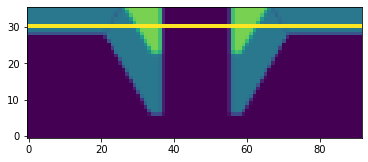

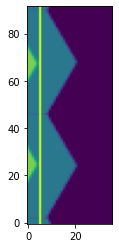

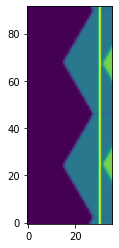

In [6]:
conf.update(
    add_seg = True,
    seg_width = 1.45,
    seg_gap = 0.004,
    seg_ptv = 0,
)
filename_seg = 'ELT_fullM1_nov2024_seg1.45.fits'
try:
    mask_seg = fits.getdata(filename_seg)
except FileNotFoundError:
    wf = heeps.pupil.pupil(**conf)
    mask_seg = get_wf(wf, 'amp', npupil=conf['npupil'])
    fits.writeto(filename_seg, mask_seg)
# add ESO mask
mask_seg += (mask_noseg-0.5)
# add a 30-segment frame
tot_seg_width = (30*conf['seg_width']*np.cos(np.radians(30)))/conf['pupil_img_size'] * conf['npupil']
margin = (conf['npupil'] - tot_seg_width) // 2
margin = int(margin)
mask_seg[margin,:] = 2
mask_seg[-margin-1,:] = 2
mask_seg[:,margin] = 2
mask_seg[:,-margin-1] = 2
# zoom to center
c = conf['npupil'] // 2
v = conf['npupil'] // 6
plt.figure(), plt.imshow(mask_seg[c-v:c+v,c-v:c+v], origin='lower');
# zoom to pupil edges
w = conf['npupil'] // 30
plt.figure(), plt.imshow(mask_seg[-w:-10,c-w:c+w], origin='lower');
plt.figure(), plt.imshow(mask_seg[10:w,c-w:c+w], origin='lower');
plt.figure(), plt.imshow(mask_seg[c-w:c+w,-w:-10], origin='lower');
plt.figure(), plt.imshow(mask_seg[c-w:c+w,10:w], origin='lower');

In [7]:
# adapt 'seg_width' to match 'mask_noseg'
conf.update(
    seg_width = 1.417,#1.45,
)
filename_fullM1 = 'ELT_fullM1_nov2024.fits'
try:
    mask_fullM1 = fits.getdata(filename_fullM1)
except FileNotFoundError:
    wf = heeps.pupil.pupil(**conf)
    mask_fullM1 = get_wf(wf, 'amp', npupil=conf['npupil']) * mask_noseg
    fits.writeto(filename_fullM1, mask_fullM1)

In [8]:
# RMS to PTV conversion
np.random.seed(123456)
nseg = 798
rms = 0.01
segs = np.random.normal(1, rms, nseg)
print('%s RMS = %.2f PtV'%(rms, np.ptp(segs)))
rms = 0.02
segs = np.random.normal(1, rms, nseg)
print('%s RMS = %.2f PtV'%(rms, np.ptp(segs)))
rms = 0.03
segs = np.random.normal(1, rms, nseg)
print('%s RMS = %.2f PtV'%(rms, np.ptp(segs)))

0.01 RMS = 0.07 PtV
0.02 RMS = 0.13 PtV
0.03 RMS = 0.20 PtV


In [9]:
# with segment reflectivity
filename_ptv = 'ELT_fullM1_nov2024_refl_%.2fptv.fits'
for seg_ptv in tqdm([0.05, 0.10, 0.15]):
    try:
        mask_ptv = fits.getdata(filename_ptv%seg_ptv)
    except FileNotFoundError:
        conf.update(seg_ptv=seg_ptv)
        wf = heeps.pupil.pupil(**conf)
        mask_ptv = get_wf(wf, 'amp', npupil=conf['npupil']) * mask_noseg
        fits.writeto(filename_ptv%seg_ptv, mask_ptv)

100%|██████████| 3/3 [00:00<00:00, 54.20it/s]


# 3. Misaligned segments

In [10]:
filename_misseg = 'ELT_fullM1_nov2024_misseg_%sx7.fits'
misseg1 = [(-2,5),(-2,6),(-3,4),(-3,5),(-3,6),(-4,5),(-4,6)]
misseg2 = [(13,11),(13,12),(14,9),(14,10),(14,11),(15,8),(15,9)]
conf.update(seg_ptv=0)
for i, seg_missing in tqdm(enumerate([misseg1, misseg1+misseg2])):
    try:
        mask_misseg2 = fits.getdata(filename_misseg%(i+1))
    except FileNotFoundError:
        conf.update(seg_missing=seg_missing)
        wf = heeps.pupil.pupil(**conf)
        mask_misseg2 = get_wf(wf, 'amp', npupil=conf['npupil']) * mask_noseg
        fits.writeto(filename_misseg%(i+1), mask_misseg2)
    if i==0:
        mask_misseg1 = mask_misseg2

2it [00:00, 78.89it/s]


In [11]:
# analysis
conf.update(
    nframes = 1,
    hfov = 0.8,
    add_phase = False,
    ngrid = 2048,
    diam_ext = 36.905,
    diam_int = 11.213,
    norm_I = True,
    add_seg = False,
)
conf = heeps.config.update_config(**conf, verbose=True)
wf = heeps.pupil.pupil(**conf)
peak = np.max(heeps.wavefront.propagate(wf, onaxis=False, **conf))
print('\npeak = %.4f'%peak)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.69 lam/D)

dRext=0, dRint=0, dRspi=0, circ_ext=True, circ_int=True, AP_angles=[0], add_seg=False
   2024-12-09 16:05:10, e2e simulation using 12 cores
   2024-12-09 16:05:17, completed in 6.43 seconds

peak = 0.0114


<Figure size 432x288 with 0 Axes>

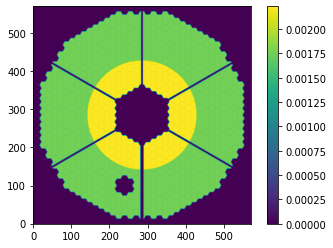

<Figure size 432x288 with 0 Axes>

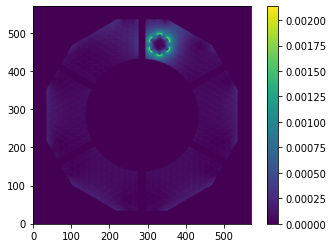

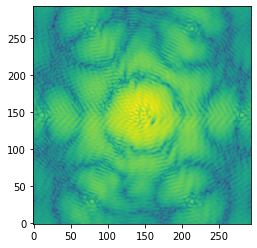

<Figure size 432x288 with 0 Axes>

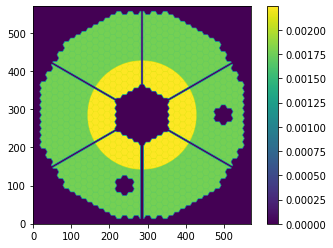

<Figure size 432x288 with 0 Axes>

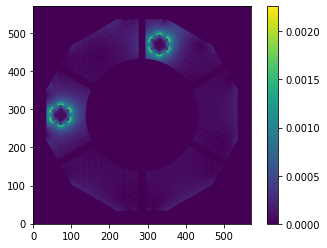

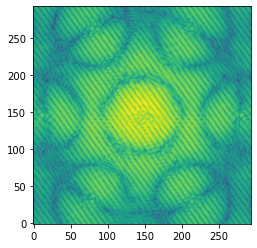

In [12]:
for i, mask_misseg in enumerate([mask_misseg1, mask_misseg2]):
    wf = heeps.pupil.pupil(pup=mask_misseg, **conf)
    wf = heeps.optics.apodizer(wf, **conf)
    plt.figure(); apo = show_wf(wf, 'amp', npupil=conf['npupil']);
    wf = heeps.optics.fp_mask(wf, **conf)
    wf = heeps.optics.lyot_stop(wf, **conf)
    plt.figure(); ls = show_wf(wf, 'amp', npupil=conf['npupil']);
    psf = heeps.optics.detector(wf, **conf)
    psf /= peak
    plt.figure(); plt.imshow(np.log10(psf), origin='lower');
    fits.writeto('misseg_apo%s.fits'%(i+1), apo, overwrite=True)
    fits.writeto('misseg_ls%s.fits'%(i+1), ls, overwrite=True)
    fits.writeto('misseg_psf%s.fits'%(i+1), psf, overwrite=True)

# 4. Segment reflectivity + 7 misaligned segments

In [13]:
conf.update(
    ngrid = ngrid,
    npupil = npupil,
    diam_ext = 80,
    diam_int = 0,
    norm_I = True,
    add_seg = True,
    seg_width = 1.417,#1.45,
    seg_ptv = 0.10,
    seg_missing = misseg1,
)
filename_ptv_misseg = 'ELT_fullM1_nov2024_refl_%.2fptv_misseg_%sx7.fits'%(conf['seg_ptv'], 1)
try:
    mask_ptv_misseg = fits.getdata(filename_ptv_misseg)
except FileNotFoundError:
    wf = heeps.pupil.pupil(**conf)
    mask_ptv_misseg = get_wf(wf, 'amp', npupil=conf['npupil']) * mask_noseg
    fits.writeto(filename_ptv_misseg, mask_ptv_misseg)

# 5. All effects

In [14]:
conf = dict(
    mode = 'ELT',
    add_phase = False,
    nframes_avg = 1,
    hfov = 1.065,
    ngrid = 2048,
    f_pupil = filename_ptv_misseg,
)
conf = heeps.config.read_config(**conf)
conf['band_specs']['L']['pscale'] = 5.47/2
conf = heeps.config.update_config(**conf)
wf = heeps.pupil.pupil(**conf)
psf = heeps.wavefront.propagate(wf, avg=True, **conf)
elt_peak = np.max(psf)
print('ELT peak = %.4f'%elt_peak)

dRext=0, dRint=0, dRspi=0, circ_ext=True, circ_int=True, AP_angles=[], add_seg=False
   2024-12-09 16:05:31, e2e simulation using 12 cores
   2024-12-09 16:05:34, completed in 2.98 seconds
ELT peak = 0.0114


Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.1284
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=2.7350 mas, lam=3.8112E-06 m
   hfov=1.07 arcsec (-> ndet=779, 50.01 lam/D)

Entrance pupil: created with dRext=0, dRint=0, dRspi=0, circ_ext=True, circ_int=True, AP_angles=[], add_seg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_all_ncpa_L_285.fits'
   nscreens=100 (nframes=100, nstep=1)
Load amp screens from 'LM_rep_6_-0h30.fits'
   nscreens=100
Load apodizer drift=0.02 % ptv
Create on-axis PSF cube
   amplitude screen not preloaded: len(amp_screens)=100
   RAVC apodizer not preloaded: len(apo_misalign)=100
   apply vortex phase mask
   adding chromatic leakage at vortex plane: 0.002
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalig

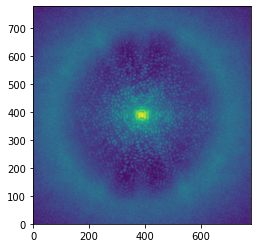

In [15]:
conf = dict(
    add_phase = True,
    f_phase = 'wavefront/cfull/cube_Cfull_20220512_3600s_300ms_0piston_meters_all_ncpa_L_285.fits',
    add_apo_drift = True,
    apo_drift = 0.02,
    add_amp = True,
    f_amp = 'wavefront/cbw/20221006/talbot/LM_rep_6_-0h30.fits',
    add_cl_vort = True,
    vc_chrom_leak = 2e-3,
    nframes_avg = 100,
    hfov = 1.065,
    ngrid = 2048,
    f_pupil = filename_ptv_misseg,
)
conf = heeps.config.read_config(**conf)
conf['band_specs']['L']['pscale'] = 5.47/2
verbose = True
conf = heeps.config.update_config(**conf, verbose=verbose)
wf = heeps.pupil.pupil(**conf, verbose=verbose)
psf = heeps.wavefront.propagate(wf, avg=True, **conf, verbose=verbose)
psf /= elt_peak
fits.writeto('all_effects_L_RAVC_long.fits', psf, overwrite=True)
plt.imshow(np.log10(psf), origin='lower');